In [ ]:
pip install arch

In [68]:
from arch import arch_model
import numpy as np
from main import get_pair_tickers
import pandas as pd
import itertools
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

def garch_relevant_parameters(stock_data, alpha_max = .35):
    aic = []
    max_alpha = alpha_max
    scaled_returns = stock_data['close'].pct_change().dropna()*100
    params = [1, 0]
    model = arch_model(scaled_returns, p=params[0], q=params[1], dist='t').fit(disp='off')
    max_pval = np.max(model.pvalues[1:])
    aic.append(params + [model.aic, model.bic, model.loglikelihood,  model.pvalues[1:].mean()])
    if max_pval > max_alpha :
        print('GARCH process is not available for this stock')
        return None
    else :
        #searching for maximum significant coefficient with p
        while max_pval < max_alpha :
            params[0] += 1
            model = arch_model(scaled_returns, p=params[0], q=params[1], dist='t').fit(disp='off')
            max_pval = np.max(model.pvalues[1:])

        #for p in [1, ..., max_p-1], search for q until it is unsignificant
        for i in range(1,params[0]):
            params[0], params[1] = i, 0
            max_pval = np.max(arch_model(scaled_returns, p=params[0], q=params[1]).fit(disp='off').pvalues[1:])
            while max_pval < max_alpha :
                model = arch_model(scaled_returns, p=params[0], q=params[1], dist='t').fit(disp='off')
                max_pval = np.max(model.pvalues[1:])    
                aic.append(params + [model.aic, model.bic, model.loglikelihood, model.pvalues[1:].mean()])
                params[1] += 1
            aic = aic[:-1]
        return pd.DataFrame(list(aic for aic,_ in itertools.groupby(aic)), columns = ['p','q','aic','bic','log','pval.mean'])

def best_garch_model(stock_data):
    scaler = MinMaxScaler()
    significants_params = garch_relevant_parameters(stock_data)
    if significants_params is None:
        return None
    else :
        metrics = significants_params.iloc[:,2:-1]
        scaler.fit(metrics)
        scaled_metrics = scaler.transform(metrics)
        significants_params['custom score'] = pd.Series([x.sum() for x in scaled_metrics])
        optimal_params = significants_params.sort_values(by=['custom score']).iloc[0,0:2]
        return optimal_params.astype(int).values
    
#student T garch
def historical_garch_signal(stock_data, params):
    scaled_returns = stock_data['close'].pct_change().dropna()*100
    optimal_model = arch_model(scaled_returns, p=int(params[0]), q=int(params[1]), dist='t').fit(disp='off')
    rolling_predictions = []
    test_size = 365   
    for i in tqdm(range(len(stock_data))):
        train = scaled_returns[:-(test_size-i)]
        model = arch_model(train, p=1, q=1, dist='t').fit(disp='off')
        pred = model.forecast(horizon=1,reindex=True)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    return rolling_predictions

In [280]:
usdt_tickers = get_pair_tickers()
data = pd.read_pickle(f'usdt_data/{usdt_tickers[1]}.pickle').astype(float)
data = data[['open','high','low','close','volume','trades']].dropna()

In [272]:
garch_relevant_parameters(data.iloc[-2000:])

,p,q,aic,bic,log,pval.mean
0,1,0,1126.441601,1148.843211,-559.220801,1.190526e-12
1,1,1,817.602866,845.604878,-403.801433,6.615152e-03
2,1,2,816.241367,849.843781,-402.120684,5.458840e-03
3,1,3,813.765391,852.968208,-399.882696,4.245183e-02
4,2,0,1025.856950,1053.858962,-507.928475,1.551191e-07
5,3,0,973.949144,1007.551558,-480.974572,2.206365e-05
6,4,0,928.363941,967.566758,-457.181971,8.845886e-05
7,5,0,920.592146,965.395365,-452.296073,8.532081e-03
8,6,0,898.466823,948.870444,-440.233412,3.323625e-02


In [273]:
best_garch_model(data.iloc[-2000:])

array([1, 1])

In [ ]:
#4h for 1 dataset.....
historical_garch_signal(data, params = best_garch_model(data.iloc[-2000:]))

In [ ]:
import scipy
def rho_cal(X):
    rho_hat =  scipy.stats.pearsonr(X-np.mean(X), np.sign(X-  np.mean(X)))#rho_hat[0]:Pearson correlation , rho_hat[1]:two-tailed p-value
    return rho_hat[0]
def custom_volatility(y,l,alpha,plot_last,plot=True): #y = squared returns
    #mettre une condition si
    t = len(y)
    rho = rho_cal(y) # calcul de la correlation entre les log returns centrés et les signes des log return centrés
    vol = abs(y-np.mean(y))/rho # volatilité observée chaque jour
    MSE_alpha = np.zeros(len(alpha)) #initialisation du stockage des MSE pour chaque alpha
    sn = np.zeros(len(alpha))#initialisation du stockage de la volatilité pour chaque alpha
    historicals = []
    for a in range(len(alpha)):
        spred =  np.mean(vol[0:l]) # calcul de la volalitilité moyenne a partir des n_cut_t premieres volatilités
        error = np.zeros(t-l)
        historical = []
        historical.append(spred)
        for i in range(t-l):
            error[i] = vol[i+l] - spred #erreurs entre la volatilité estimée avec rho et reelle à chaque période (1 fois ^par jour)
            spred = alpha[a]*vol[i+l-1]+(1-alpha[a])*spred
            historical.append(spred)
        spred = alpha[a]*vol[i+l]+(1-alpha[a])*spred
        historical.append(spred)
        historicals.append(historical)
        MSE_alpha[a] = np.mean(error**2) # mesure de l'erreur moyenne avec le FESS pour chaque alpha
        sn[a] = spred #volatilité prédite (chaque jour car range(t)) stockée pour chaque alpha
    min_fss_pos = np.argmin(MSE_alpha)
    vol_forecast = sn[min_fss_pos] #which min
    optimal_alpha = alpha[min_fss_pos]
    RMSE = np.sqrt(min(MSE_alpha))
    
    predictions = historicals[min_fss_pos]
    observed_volatility = vol.values
    #print(len(predictions),len(observed_volatility[l:]))
    if plot != False:
        plt.plot(observed_volatility[t-plot_last:])
        plt.plot(predictions[t-plot_last-l:])
    return RMSE, optimal_alpha, predictions

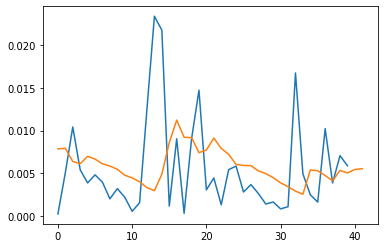

In [282]:
r,a,preds = custom_volatility(y,10,np.linspace(0.2,0.8,num=100),40)

Iteration:      5,   Func. Count:     39,   Neg. LLF: 71630.22287629421
Iteration:     10,   Func. Count:     70,   Neg. LLF: 57168.877340224964
Optimization terminated successfully    (Exit mode 0)
            Current function value: 57168.86457966584
            Iterations: 13
            Function evaluations: 84
            Gradient evaluations: 13


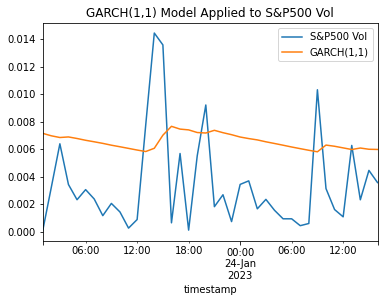

In [281]:
y_scaled = data['close'].pct_change().dropna()*100
y = data['close'].pct_change().dropna()
am = arch_model(y_scaled, p=1, q=1) #GARCH MODEL p=1 , q=1 #dist t moins bien
res = am.fit(update_freq=5)#, disp='off')
df = pd.DataFrame({'S&P500 Vol':np.abs(y),'GARCH(1,1)':res.conditional_volatility/100})
subplot = df.iloc[-40:,:].plot(title = 'GARCH(1,1) Model Applied to S&P500 Vol')

In [322]:
import numpy as np

RMSE = []
alpha = []
alphas = np.linspace(0.01,0.8,num=100)
for i in tqdm(alphas):
    r,a,p = custom_volatility(y,30,[i],40,plot=False)
    RMSE.append(r)
    alpha.append(i)
    
    
coefficients = np.polyfit(alpha, RMSE, 3)

x_values = np.linspace(min(alpha), max(alpha), 100)
y_values = np.poly1d(coefficients)(x_values)

xmin = -coefficients[1]/(3*coefficients[0])
ymin = np.poly1d(coefficients)(xmin)
xmin,ymin

100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


(0.7243190053139104, 0.014555821043931818)

In [291]:
alphaopt = np.max([0.1,np.min([xmin,0.75])])

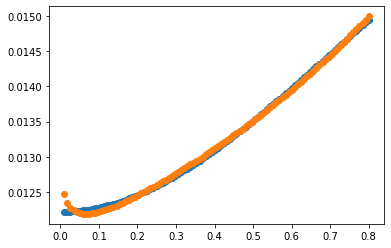

In [290]:
plt.scatter(alpha,y_values)
plt.scatter(alpha,RMSE)

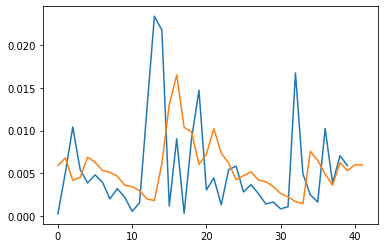

In [321]:
r,a,preds = custom_volatility(y,30,[0.4],40,plot=True)

<AxesSubplot: xlabel='timestamp'>

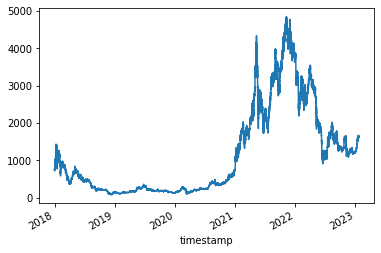

In [313]:
data['close'].plot()

In [294]:
preds_df = pd.DataFrame(preds,columns=['n+1 pred volat'])
preds_df.index = data.index[-len(preds_df):]
preds_df.tail()

,n+1 pred volat
timestamp,
2023-01-24 12:00:00,0.002181
2023-01-24 13:00:00,0.008028
2023-01-24 14:00:00,0.004993
2023-01-24 15:00:00,0.006495
2023-01-24 16:00:00,0.006043


In [307]:
output = pd.concat([data, preds_df], axis=1)

In [319]:
output

,open,high,low,close,volume,trades,n+1 pred volat
timestamp,,,,,,,
2018-01-01 00:00:00,733.01,734.52,720.03,727.62,2105.90100,3114.0,NaN
2018-01-01 01:00:00,727.01,732.00,716.80,717.97,2305.97086,2875.0,NaN
2018-01-01 02:00:00,717.67,725.75,717.59,724.05,2166.45725,2957.0,NaN
2018-01-01 03:00:00,723.95,737.99,722.70,734.50,2160.90450,3647.0,NaN
2018-01-01 04:00:00,734.99,744.98,730.01,744.82,2335.33705,3512.0,NaN
...,...,...,...,...,...,...,...
2023-01-24 12:00:00,1625.59,1632.12,1622.22,1627.34,9920.66530,16233.0,0.002181
2023-01-24 13:00:00,1627.34,1630.76,1612.83,1617.14,18600.23910,25777.0,0.008028
2023-01-24 14:00:00,1617.14,1622.48,1604.00,1613.40,41583.72390,46586.0,0.004993


<AxesSubplot: >

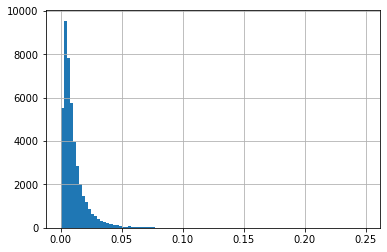

In [308]:
output['n+1 pred volat'].hist(bins=100)

In [305]:
output['n+1 pred volat'] = output['n+1 pred volat'].shift(-1)